# PyTorch

This Jupyter notebook builds a model for detecting the beginning of seismic quakes using neural networks from `PyTorch`.


### Import Modules


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision

from tqdm import tqdm

### Import Data


In [2]:
# Import Datasets
lunar_dir = os.path.join(os.path.curdir, r"..\..\data\lunar")

training_data = pd.read_csv(
    os.path.join(
        lunar_dir,
        r"training\data\S12_GradeA\xa.s12.00.mhz.1970-01-19HR00_evid00002.csv",
    )
)
training_data = training_data.drop(columns=["time_rel(sec)"])
training_data = training_data.drop(columns=["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
# training_data = training_data.set_index(r"time_abs(%Y-%m-%dT%H:%M:%S.%f)")


# catalog = pd.read_csv(os.path.join(lunar_dir, r'training\catalogs\apollo12_catalog_GradeA_final.csv'))

test_data = pd.read_csv(
    os.path.join(
        lunar_dir, r"test\data\S12_GradeB\xa.s12.00.mhz.1969-12-16HR00_evid00006.csv"
    )
)

# for file in os.listdir(lunar_training_data_dir):
#     if file.endswith('.csv'):
#         df = pd.read_csv(os.path.join(lunar_training_data_dir, file))
#         print(df.head())
#         print(df.shape)
#         break

# training_data
# catalog
# test_data
print(training_data["velocity(m/s)"].shape)
training_data

(572415,)


,velocity(m/s)
0,-6.153279e-14
1,-7.701288e-14
2,-8.396187e-14
3,-8.096155e-14
4,-7.097599e-14
...,...
572410,-1.472713e-14
572411,-1.956104e-14
572412,-2.240307e-14
572413,-2.998405e-14


In [3]:
# Visualize Data

In [4]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i : i + window_size])
    return np.array(sequences)


# sequences = [
#     [11 elements from 0 to 10]
#     [11 elements from 1 to 11]
#     [11 elements from 2 to 12]
#     ...
#     [11 elements from 572405 to 572415]
# ]


window_size = 16
sequences = create_sequences(training_data["velocity(m/s)"], window_size)

In [5]:
# Define Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(16, 8, 1),
            nn.ReLU(True),
            nn.Dropout(0.5),
            #
            nn.Conv1d(8, 4, 1),
            nn.ReLU(True),
            nn.Dropout(0.5),
            #
            nn.Conv1d(4, 2, 1),
            nn.ReLU(True),
            nn.Dropout(0.5),
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(2, 4, 1),
            nn.ReLU(True),
            nn.Dropout(0.5),
            #
            nn.Conv1d(4, 8, 1),
            nn.ReLU(True),
            nn.Dropout(0.5),
            #
            nn.Conv1d(8, 16, 1),
            nn.ReLU(True),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
sequences = torch.tensor(sequences, dtype=torch.float32)
len(sequences)

572399

In [7]:
# Set Hyperparameters
num_epochs = 8
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(sequences)
    loss = criterion(output, sequences)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

RuntimeError: Given groups=1, weight of size [8, 16, 1], expected input[1, 572399, 16] to have 16 channels, but got 572399 channels instead

In [11]:
# Anomaly Detection
with torch.no_grad():
    predictions = model(sequences)
    losses = torch.mean((predictions - sequences) ** 2, dim=1)
    plt.hist(losses.numpy(), bins=50)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")

# Threshold for defining an anomaly
threshold = losses.max() - losses.std()
print(f"Anomaly threshold: {threshold.item()}")

# Detecting anomalies
anomalies = losses > threshold
anomaly_positions = np.where(anomalies.numpy())[0]
print(f"Anomalies found at positions: {anomaly_positions}")

RuntimeError: Given groups=1, weight of size [16, 16384, 1], expected input[1, 1, 128] to have 16384 channels, but got 1 channels instead

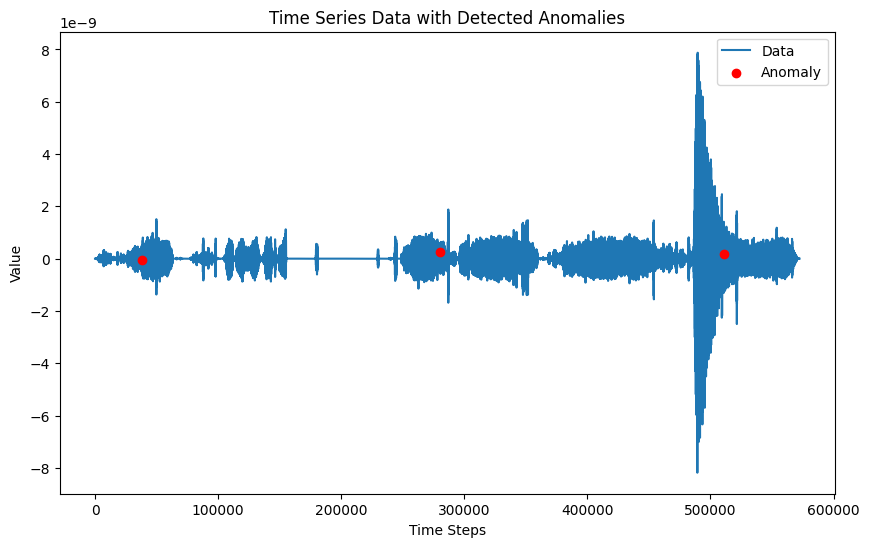

In [151]:
# Plotting anomalies on the time-series graph
plt.figure(figsize=(10, 6))
plt.plot(training_data, label="Data")

plt.scatter(
    anomaly_positions,
    training_data["velocity(m/s)"].values[anomaly_positions],
    color="r",
    label="Anomaly",
    zorder=2,
)
plt.title("Time Series Data with Detected Anomalies")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()